In [2]:
from langchain_groq import ChatGroq

from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode
import os

load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm=ChatGroq(model_name="Gemma2-9b-It",groq_api_key=os.getenv("GROQ_API_KEY"))
llm_with_tools = llm.bind_tools(tools=tools)

def model(state: AgentState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: AgentState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

graph = StateGraph(AgentState)

graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")

graph.add_conditional_edges("model", tools_router)
graph.add_edge("tool_node", "model")

app = graph.compile()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9860\3838602714.py:16: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=2)


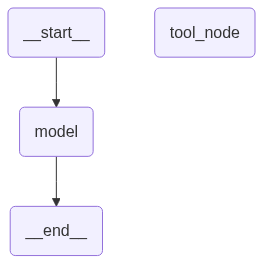

In [3]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [4]:
input = {
    "messages": ["What's the current weather in Bangalore?"]
}

events = app.stream(input=input, stream_mode="values")

for event in events: 
    print(event["messages"])    

[HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='8c8f0339-dd8b-4098-a64f-bc127512571b')]
[HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='8c8f0339-dd8b-4098-a64f-bc127512571b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'p5kf5tpeh', 'function': {'arguments': '{"query":"weather in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 989, 'total_tokens': 1078, 'completion_time': 0.161818182, 'prompt_time': 0.019042992, 'queue_time': 0.19639948599999998, 'total_time': 0.180861174}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--41df0b88-fe64-4d0a-96cd-4d5091842bb8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bangalore'}, 'i

In [5]:
input = {
    "messages": ["What's the current weather in Bangalore?"]
}

events = app.stream(input=input, stream_mode="updates")

for event in events: 
    print(event)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rhj15wam7', 'function': {'arguments': '{"query":"current weather in Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 989, 'total_tokens': 1079, 'completion_time': 0.163636364, 'prompt_time': 0.021058662, 'queue_time': 0.191365796, 'total_time': 0.184695026}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5d436189-b254-443e-b93c-5271ef1b392a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Bangalore'}, 'id': 'rhj15wam7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 989, 'output_tokens': 90, 'total_tokens': 1079})]}}
{'tool_node': {'messages': [ToolMessage(content='[{"title": "Bangalore weather in July 2025 - Weather25.com", "url": "https://www.weather25.com/asia/ind

In [6]:
input = {
    "messages": ["Hi, how are you?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, how are you?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'e0c86fba-35b2-4b2c-a971-176c06a2f15e', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='acdeb84b-018c-4178-bd11-c2cbca5b289c')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '77255dad-2f23-4b75-8b0e-6a4171bc1cef', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:4807076b-6a45-188b-acdb-2d6a6ddff5c5'}, 'parent_ids': ['e0c86fba-35b2-4b2c-a971-176c06a2f15e']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='acdeb84b-018c-4178-bd11-c2cbca5b289c')]]}}, 'name': 'ChatGroq', 'tags': ['seq:s

In [7]:

input = {
    "messages": ["Hi, how are you?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="",flush=True)

APIError: Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.